# Computational Linear Algebra: Singular Value Decomposition Homework

In the following homework we decided to explore the topic of *Singular Value Decomposition* used to device a Movie recommendation system like the one used nowdays by many streaming services.

## 1. Dataset Specifications
The dataset we decided to use is the *MovieLens Dataset* which is one of the most widely used datasets for movie recommendation tasks. Such dataset contains user ratings for movies along with metadata like movie genres, titles, and timestamps.

In particular, we considered the "MovieLens 1M Dataset", which contains 1 million ratings from 6000 users on 4000 movies. The dataset is divided into 3 main files:
- "ratings.dat": which contains all the ratings
- "users.dat": which contains all the user information
- "movies.dat": which contains all the movie information

### Ratings dataset
All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

### Users dataset
User information is in the file "users.dat" and is in the following format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

### Movies dataset
Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

### 1.2 Singular Value Decomposition (SVD) - Theory

SVD is a matrix factorization technique for a matrix $A \in \mathbb{C}^{m \times n}$, expressed as:

$$
A = U \Sigma V^H
$$

where:
- $U$ is an orthogonal $m \times m$ matrix with left singular vectors,
- $\Sigma$ is a diagonal $m \times n$ matrix with non-negative singular values,
- $V$ is an orthogonal $n \times n$ matrix with right singular vectors.

Key properties:
- The columns of $U$ are eigenvectors of $A A^T$.
- The columns of $V$ are eigenvectors of $A^T A$.
- The diagonal elements of $\Sigma$ are the singular values, corresponding to the square roots of the eigenvalues of $A A^T$ or $A^T A$.
If $A \in \mathbb{R}^{m \times n}$, the decomposition becomes: $A = U \Sigma V^T$.

### Geometric Interpretation

The SVD represents a matrix transformation as a sequence of three operations:
1. **Rotation by $V^T$**: Aligns the input space with the right singular vectors.
2. **Scaling by $\Sigma$**: Scales along axes defined by the singular vectors.
3. **Rotation by $U$**: Rotates the output space to align with the left singular vectors.

This decomposition helps in understanding and visualizing linear transformations.


In [1]:
# Library import
from scipy.sparse.linalg import svds
from scipy.linalg import qr
from numpy.linalg import eig
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pandas as pd
import time
from wordcloud import WordCloud

student_1 = 339401
student_2 = 337625

random_code = student_1 + student_2

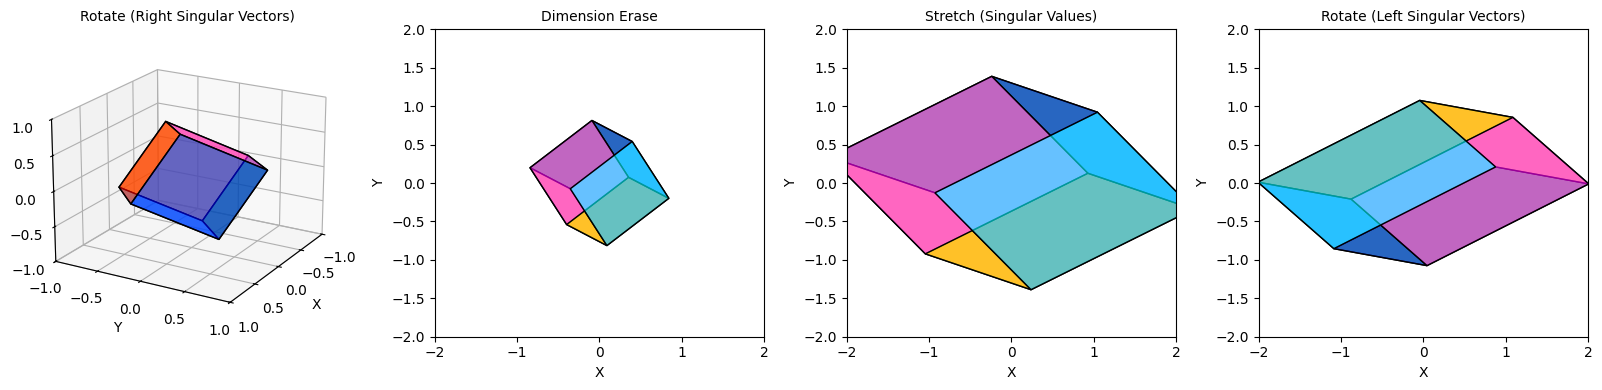

In [2]:
# Define face colors for consistency
face_colors = [
    (1, 0, 0, 0.6),  # Red
    (0, 1, 0, 0.6),  # Green
    (0, 0, 1, 0.6),  # Blue
    (1, 1, 0, 0.6),  # Yellow
    (1, 0, 1, 0.6),  # Magenta
    (0, 1, 1, 0.6)   # Cyan
]

# Function to generate a 3D parallelepiped (unit cube)
def generate_parallelepiped():
    vertices = np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # Bottom face
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]   # Top face
    ])
    return vertices - 0.5  # Center the parallelepiped

# Function to apply a linear transformation to vertices
def apply_transformation(vertices, matrix):
    return np.dot(vertices, matrix.T)

# Function to plot a colored parallelepiped in 3D
def plot_parallelepiped_3d(ax, vertices, title):
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # Bottom face
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # Top face
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Side face
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Side face
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # Side face
        [vertices[4], vertices[7], vertices[3], vertices[0]]   # Side face
    ]
    poly3d = Poly3DCollection(faces, facecolors=face_colors, linewidths=1, edgecolors='k')
    ax.add_collection3d(poly3d)

    ax.set_title(title, fontsize=10)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.view_init(elev=20, azim=30)  # Rotate POV slightly
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

# Function to plot a transformation in 2D with colors
def plot_parallelepiped_2d(ax, vertices, title):
    ax.set_title(title, fontsize=10)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Get only the first two dimensions for 2D visualization
    vertices_2d = vertices[:, :2]

    # Define corresponding faces for 2D view
    faces_2d = [
        [vertices_2d[0], vertices_2d[1], vertices_2d[2], vertices_2d[3]],  # Bottom face
        [vertices_2d[4], vertices_2d[5], vertices_2d[6], vertices_2d[7]],  # Top face
        [vertices_2d[0], vertices_2d[1], vertices_2d[5], vertices_2d[4]],  # Side face
        [vertices_2d[2], vertices_2d[3], vertices_2d[7], vertices_2d[6]],  # Side face
        [vertices_2d[1], vertices_2d[2], vertices_2d[6], vertices_2d[5]],  # Side face
        [vertices_2d[4], vertices_2d[7], vertices_2d[3], vertices_2d[0]]   # Side face
    ]

    # Plot each face with the corresponding color
    for face, color in zip(faces_2d, face_colors):
        face.append(face[0])  # Close the polygon
        face = np.array(face)
        ax.fill(face[:, 0], face[:, 1], color=color, edgecolor='k', linewidth=1)

# Define an arbitrary transformation matrix (3x3 for mapping R3 to R3)
A = np.array([[1, 2, 1], [0, 1, -1], [1, 0, 1]])

# Perform SVD decomposition
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Matrices involved in the transformation
rotation1 = Vt  # First rotation (Right singular vectors)
scaling = np.diag(S)  # Scaling matrix (Singular values)
rotation2 = U  # Second rotation (Left singular vectors)

# Original parallelepiped
vertices = generate_parallelepiped()

# Apply transformations
vertices_rot1 = apply_transformation(vertices, rotation1)  # Rotate (3D)
vertices_projected = vertices_rot1[:, :2]  # Dimension Reduction (Drop Z)
vertices_stretch = apply_transformation(vertices_projected, scaling[:2, :2])  # Stretch
vertices_rot2 = apply_transformation(vertices_stretch, rotation2[:2, :2])  # Final Rotate

# Plot results: 3D rotation, dimension reduction, 2D stretch, 2D final rotation
fig = plt.figure(figsize=(16, 4))

# First plot (3D): Rotate by right singular vectors
ax1 = fig.add_subplot(141, projection='3d')
plot_parallelepiped_3d(ax1, vertices_rot1, "Rotate (Right Singular Vectors)")

# Second plot (2D): Dimension Reduction (Projection to 2D)
ax2 = fig.add_subplot(142)
plot_parallelepiped_2d(ax2, vertices_projected, "Dimension Erase")

# Third plot (2D): Stretch by singular values
ax3 = fig.add_subplot(143)
plot_parallelepiped_2d(ax3, vertices_stretch, "Stretch (Singular Values)")

# Fourth plot (2D): Rotate by left singular vectors
ax4 = fig.add_subplot(144)
plot_parallelepiped_2d(ax4, vertices_rot2, "Rotate (Left Singular Vectors)")

plt.tight_layout()
plt.show()

## 2. Dataset preparation
### 2.3 Loading the separate datasets

In [3]:
# Load ratings.dat
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Load movies.dat
movies = pd.read_csv('ml-latest-small/movies.csv')

# Display the first few rows
print("Ratings:")
print(ratings.head())
print("\nMovies:")
print(movies.head())

Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


### 2.2 Merge DataFrames
We’ll merge the ratings, movies, and users DataFrames to create a single dataset for analysis.
- For each genre in the row we create a new row with the same values as the original row but with the genre value as the new value. This is done for each row.

In [4]:
# Merge ratings with movies
full_data = pd.merge(ratings, movies, on='movieId')

# Display the merged dataset
print("Merged Data:")
full_data.head()

Merged Data:


userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller

## 3. Preprocessing
In order to apply the SVD decomposition we need to preprocess the data in the dataset.
### 3.1 Normalize ratings
We normalize the ratings to ensure fair comparison across users.

In [5]:
# Normalize the ratings
scaler = StandardScaler()
full_data['normalized_rating'] = scaler.fit_transform(full_data[['rating']])

print(f"Normalized Ratings (mean={full_data['normalized_rating'].mean()}, std={full_data['normalized_rating'].std()}):")
full_data[['rating', 'normalized_rating']].head()

Normalized Ratings (mean=2.0998625020479775e-16, std=1.0000049585834319):


rating  normalized_rating
0     4.0           0.478112
1     4.0           0.478112
2     4.0           0.478112
3     5.0           1.437322
4     5.0           1.437322

## 4. Data Matrix
In order to apply SVD we transform the dataset into a  user-item matrix where rows are users, columns are movies, and values are ratings.


In order to properly test our model, we splitted the dataset into development and evaluation by using an hold-out technique with 80% development and 20% evaluation.

In [6]:
# Splitting the dataset into 80% training and 20% testing with representative sampling
train, test = train_test_split(full_data, test_size=0.2, random_state=random_code)

## 5. Perform SVD
We preform Singular Value Decomposition on the user-item matrix.

In [7]:
def bidiagonal(A):
    m, n = A.shape
    B = A.copy()  # Make a copy of A for modification
    P = np.eye(m)  # Initialize the orthogonal matrix P
    H = np.eye(n)  # Initialize the orthogonal matrix H
    
    for k in range(n):
        # Construct Householder vector for column k
        a = B[k:, k].copy()
        a[0] += np.sign(a[0]) * np.linalg.norm(a)
        P_tilde = np.eye(m)
        P_tilde[k:, k:] -= 2 * np.outer(a, a) / np.dot(a, a)  # Outer product instead of dot product
        
        # Update matrix B and P
        B = P_tilde @ B
        P = P_tilde @ P
        
        if k < n - 1:  # Only need to reflect in the row direction for k < n-1
            # Construct Householder vector for row k
            b = B[k, k+1:].copy()
            b[0] += np.sign(b[0]) * np.linalg.norm(b)
            H_tilde = np.eye(n)
            H_tilde[k+1:, k+1:] -= 2 * np.outer(b, b) / np.dot(b, b)  # Outer product instead of dot product
            
            # Update matrix B and H
            B = B @ H_tilde
            H = H @ H_tilde
    
    return P, B, H

In [8]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
P, B, H = bidiagonal(A)

In [9]:
def my_svd(A):
    _, B , H = bidiagonal(A)
    
    # Compute eigenvalues and eigenvectors of B^T B
    eigvals, Q_tilde = eig(B.T@B, )
    
    # Sort the eigenvalues in descending order and order Q_tilde accordingly
    sorted_indices = np.argsort(-eigvals)  # Sort in descending order
    eigvals = np.sqrt(np.abs(eigvals[sorted_indices]))  # Singular values (square root of eigenvalues)
    Q_tilde = Q_tilde[:, sorted_indices]

    # Compute the right singular vectors
    V = Q_tilde
    
    # Compute the left singular vectors
    Q = H @ Q_tilde
    
    # Construct the diagonal matrix S with singular values
    S = np.diag(eigvals)
    
    # Compute the C matrix (A @ V)
    C = A @ Q
    
    # Perform QR decomposition to obtain U and R
    U, R, p = qr(C, pivoting=True)
    P = np.eye(C.shape[1])[:, p]
    V = Q @ P
    S = np.zeros(A.shape)
    for i in range(min(R.shape)):
        if R[i, i] < 0:
            R[:, i] = -R[:, i]  
            U[:, i] = -U[:, i]
        S[i, i] = R[i, i]
    return U, S, V

In [10]:
def my_svd_k(A, k):
    _, B, H = bidiagonal(A)      

    # Compute top-k eigenpairs directly
    eigvals, Q_tilde = eigsh(B.T @ B, k=k, which='LM')

    # Compute the right singular vectors
    V_k = Q_tilde
    
    # Compute the left singular vectors
    Q_k = H @ Q_tilde
    
    # Compute the C matrix (A @ V_k)
    C_k = A @ Q_k

    # Perform QR decomposition to obtain U_k and R_k
    U_k, R_k, p = qr(C_k, pivoting=True)
    P_k = np.eye(C_k.shape[1])[:, p[:k]]
    V_k = Q_k @ P_k

    # Construct S_k with top k singular values
    S_k = np.zeros((k, k))
    for i in range(k):
        if R_k[i, i] < 0:
            R_k[:, i] = -R_k[:, i]
            U_k[:, i] = -U_k[:, i]
        S_k[i, i] = R_k[i, i]

    return U_k[:,:k], S_k, V_k.T

In [11]:
A = np.random.rand(10, 5)

# TODO: remove this note
There seems to be a problem with the sign of U and V -> it's not constant and it oscillates between negative and positive.
It seems, however, to be working correctly since the approximated matrix is the same as the one produced by svds

In [12]:
U, S, V = my_svd_k(A, 2)
U_1, S_1, V_1 = svds(A, k=2)
print(U.shape, S.shape, V.shape)
print("The approximated matrix is ", U @ S @ V)
# Sort the singular values in descending order
sorted_indices = np.argsort(S_1)[::-1]  # Indices for sorting in descending order
S_1 = S_1[sorted_indices]           # Sort singular values
U_1 = U_1[:, sorted_indices]                # Reorder columns of U
V_1 = V_1[sorted_indices, :]              # Reorder rows of V^T
S_1 = np.diag(S_1)  # Convert to diagonal matrix
print(U_1.shape, S_1.shape, V_1.shape)
print("The approximated matrix is ", U_1 @ S_1 @ V_1)

(10, 2) (2, 2) (2, 5)
The approximated matrix is  [[0.39656257 0.32263463 0.45777971 0.60187429 0.98351512]
 [0.73611796 1.0283765  0.84031388 0.68247901 0.14365669]
 [0.54148413 0.66700217 0.6200961  0.59258922 0.4560453 ]
 [0.61826311 0.69477253 0.70948986 0.74423922 0.78234146]
 [0.31417186 0.35486038 0.36048916 0.37635466 0.39045988]
 [0.33271787 0.23011283 0.38497108 0.54605161 0.984093  ]
 [0.50445713 0.49407643 0.5804914  0.68094296 0.92346432]
 [0.74914091 0.86163016 0.85924434 0.88175823 0.87047337]
 [0.74050342 0.99994522 0.84607951 0.72152611 0.27985073]
 [0.33440463 0.27326102 0.38600018 0.50632404 0.82467047]]
(10, 2) (2, 2) (2, 5)
The approximated matrix is  [[0.39656257 0.32263463 0.45777971 0.60187429 0.98351512]
 [0.73611796 1.0283765  0.84031388 0.68247901 0.14365669]
 [0.54148413 0.66700217 0.6200961  0.59258922 0.4560453 ]
 [0.61826311 0.69477253 0.70948986 0.74423922 0.78234146]
 [0.31417186 0.35486038 0.36048916 0.37635466 0.39045988]
 [0.33271787 0.23011283 0.384

### 5.1 **Weighted SVD (WSVD) for Handling Missing Values in Recommender Systems**

**Weighted Singular Value Decomposition (WSVD)** is an extension of standard **SVD** that explicitly accounts for missing values by introducing a weight matrix. This approach avoids bias from simple mean imputation while still leveraging matrix factorization for recommendations.

#### **1. How Does Weighted SVD Work?**
Instead of treating missing values as zeros or averages, WSVD assigns **weights** to known and unknown values:

- **Observed ratings (known values):** Weight = 1  
- **Missing ratings (unknown values):** Weight = 0

**Optimization Objective**
The loss function to minimize in WSVD is:

$$
\min_{U,V} \sum_{(u,i) \in R} W_{ui} (R_{ui} - U_i V_i^T)^2 + \lambda (||U||^2 + ||V||^2)
$$

where:
- $ R_{ui} $ is the known rating for user $ u $ and item $i$.
- $ U $ and $ V $ are the user and item latent factor matrices.
- $ W_{ui} $ is a binary weight matrix:
  $
  W_{ui} =
  \begin{cases} 
  1, & \text{if } R_{ui} \text{ is observed} \\
  0, & \text{if } R_{ui} \text{ is missing}
  \end{cases}
  $
- $ \lambda $ is a regularization term to prevent overfitting.

**Key Idea**
Unlike standard **SVD**, which requires a complete matrix, WSVD **only optimizes over known values**, meaning missing values do not affect factorization directly.

#### **2. Algorithm for Weighted SVD**
**Step 1: Initialize Matrices**
- Create user and item latent factor matrices **U** and **V** with random values.
- Set weight matrix **W**, assigning:
  - $ W_{ui} = 1 $ for known ratings
  - $ W_{ui} = 0 $ for missing ratings

**Step 2: Alternating Least Squares (ALS)**
- Solve for **U** while keeping **V** fixed:
  $
  U = (V^T W V + \lambda I)^{-1} V^T W R
  $
- Solve for **V** while keeping **U** fixed:
  $
  V = (U^T W U + \lambda I)^{-1} U^T W R
  $
- Iterate until convergence.

**Step 3: Predict Missing Ratings**
- Compute the **approximate rating matrix**:
  $
  \hat{R} = U \cdot S \cdot V^T
  $
- Use the reconstructed **$\hat{R}$** matrix to predict missing values.
 


In [13]:
def weighted_svd(R, k=2, lambda_reg=0.1, max_iter=100, tol=1e-4):
    """
    Performs Weighted SVD using ALS optimization.
    
    Parameters:
    - R: User-Item matrix with missing values filled
    - W: Weight matrix (1 for known, 0 for missing values)
    - k: Number of latent features
    - lambda_reg: Regularization term
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance
    
    Returns:
    - U: User latent factor matrix
    - S: Singular values (diagonal matrix)
    - V: Item latent factor matrix
    """
    IMPUTER = False
    if not IMPUTER:
        # Initialize utility matrices
        # Weight matrix: 1 for observed ratings, 0 for missing values
        W = (~np.isnan(R)).astype(int)  # Converts True/False to 1/0

        # Fill missing values with zeros (will be updated during optimization)
        R_filled = np.where(np.isnan(R), np.zeros(R.shape), R)

        # Initialize U, S, V using SVD
        #U, S, Vt = my_svd_k(R_filled, k=k)
        U, S, Vt = svds(R_filled, k=k)
        S = np.diag(S)  # Convert to diagonal matrix

        for iteration in range(max_iter):
            R_pred = U @ S @ Vt  # Reconstruct ratings
            R_new = W * R_filled + (1 - W) * R_pred  # Only update missing values
            
            # Compute new SVD
            #U_new, S_new, Vt_new = my_svd_k(R_new, k=k)
            U_new, S_new, Vt_new = svds(R_new, k=k)
            S_new = np.diag(S_new)

            # Convergence check
            if np.linalg.norm(R_new - R_pred) < tol:
                break

            U, S, Vt = U_new, S_new, Vt_new
    else:
        mid_range = np.nanmean(R)
        R_filled = np.where(np.isnan(R), mid_range, R)
        U, S, Vt = svds(R_filled, k=k)
    S = np.diag(S)
    sorted_indices = np.argsort(S)[::-1]  # Indices for sorting in descending order
    S = S[sorted_indices]         # Sort singular values
    S = np.diag(S)
    U = U[:, sorted_indices]                # Reorder columns of U
    Vt = Vt[sorted_indices, :]              # Reorder rows of V^T
    return U, S, Vt

In [14]:
# User-Item rating matrix (NaN represents missing values)
R = np.array([[5, 3, np.nan, 1],
              [4, np.nan, np.nan, 1],
              [1, 1, np.nan, 5],
              [np.nan, 1, 5, 4]])

In [15]:
# Run Weighted SVD
U, S, Vt = weighted_svd(R, k=2)
# Compute mean values for each column (ignoring NaNs)
col_mean = np.nanmean(R, axis=0)

# Fill missing values with column means
R_filled = np.where(np.isnan(R), col_mean, R)
U_1, S_1, Vt_1 = svds(R_filled, k=2)
# Reconstruct the predicted matrix
R_pred = U @ S @ Vt

print("Predicted Ratings Matrix:")
print(R_pred)
print("Predicted Ratings Matrix with svds:")
print(U_1 @ np.diag(S_1) @ Vt_1)

Predicted Ratings Matrix:
[[ 4.9999957   3.00000888 -1.15352853  0.99999685]
 [ 4.00000267  2.41668149 -0.64371629  0.99999488]
 [ 0.99997579  1.00008649  6.46791532  4.99992096]
 [ 1.14250832  0.99988999  4.9999343   4.00010086]]
Predicted Ratings Matrix with svds:
[[5.07491402 2.52267953 5.18064355 0.87161069]
 [4.14004951 2.05974204 4.62641266 1.26741347]
 [1.3045476  0.66404623 4.84650655 5.11145534]
 [2.85850845 1.43144057 5.29041688 3.78977179]]


### 5.2 Performing predictions
To perform a prediction of the rating of a movie $y$ from a user $x$ the procedure adopted is the following:
1. We select out of the training dataset the matrices relative to the genres of the movie $y$
2. We perform WSVD on the obtained matrix
3. Considering the users that have rated the following film we output the rating $\={r}$ of the user $\={x}$ whose similarity is the highest with the input user $x$
The similarity w.r.t. a user is computed considering *cosine similarity*
$$
cos(x,\={x}) = \frac{x\cdot \={x}}{||x||||\={x}||}
$$ 
To evaluate the predictions $\={r}$ made by our model we compute the **RMSE** w.r.t. the actual ratings given by the users $r$ as:
$$
RMSE = \sqrt{\sum_{i=1}^n\frac{(\={r}-r)^2}{n}}
$$
### 5.3 Selecting the number of Singular Values
Singular Value Decomposition (SVD) can be used to reduce data dimensionality, since it provides the best low-rank linear approximation of a given matrix. This can be achieved considering that the magnitude of each singular value represents the "*importance*" of its relative component of the decomposition. Dimensionality reduction is achieved by selecting the largest $k$ singular values, where the choice of $k$ depends on the size and structure of the data.

Given the SVD decomposition of a matrix $A$ of size $m \times n$:

$$A = U \Sigma V^T,$$

the reduced approximation of $A$ is:

$$A_k = U_k \Sigma_k V_k^T$$

where:
- $\Sigma_k$ is a $k \times k$ matrix, obtained by keeping only the first $k$ singular values,
- $U_k$ is an $m \times k$ matrix, obtained by keeping only the first $k$ columns of $U$,
- $V_k^T$ is a $k \times n$ matrix, obtained by keeping only the first $k$ rows of $V^T$.

In [16]:
# We plot the value of k against the error

temp = {}
for genre in train['genres'].unique():
    temp[genre] = train.loc[train['genres'] == genre].pivot_table(index='userId', columns='movieId', values='normalized_rating')
# Store the filtered subtable in the dictionary
mat = pd.concat(temp, axis=1)

U, S, Vt = weighted_svd(mat.values, k = min(mat.shape) - 1)

## TODO: implementare una threshold come diceva lui (controllare se sensato)


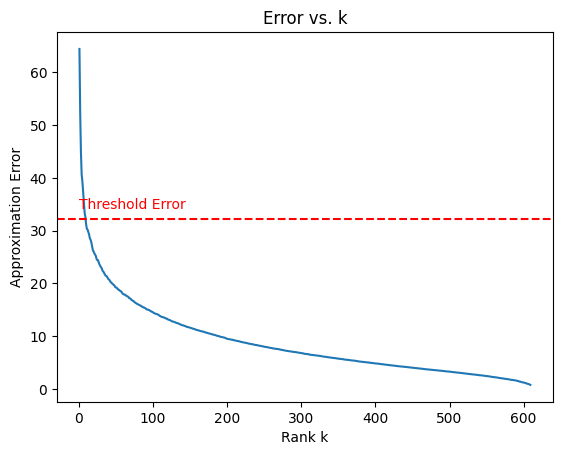

The minimum value of k such as the error is below 32.21191488897765 is: 10


In [17]:
errors = np.diag(S)
# The threshold value is the value for being below 50% of the maximum error
threshold = 0.5*np.max(errors)
plt.plot(range(1, min(mat.shape)), errors)
plt.xlabel('Rank k')
plt.ylabel('Approximation Error')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.text(1, threshold+2, 'Threshold Error', color = 'red')
plt.title('Error vs. k')
plt.show()

# We set the value of k to the minimum value such as the error is below a given threshold
K_th = np.argmax(errors < threshold) + 1

print(f"The minimum value of k such as the error is below {threshold} is:", K_th)

We considered an upper bound on the low-rank approximation error of $T/2$ (half the todal error) so that:
$$
|A-\=A| \le T/2
$$
To optimize the value of our hyperparameter $k$ we decided to perform a gridsearch to minimize the value of the RMSE with respect to the prediction value. We proceeded by performing a 3-fold cross-validation on the training dataset to obtain a more stable value for the RMSE.

#### 5.3.1 Weighted SVD Pipeline Example

In [18]:
# Prediction Pipeline - Example on a single entry
entry = train.iloc[0]
k = 20
ypred = 0


print(f"User {entry['userId']} has rated the movie {entry['title']} ({entry['genres']}) with a rating of {entry['normalized_rating']}")
train_fold = train.iloc[1:]

# Split the genres into separate rows
train_fold = train_fold.assign(genres=train_fold['genres'].str.split('|')).explode('genres')

# Create an empty dictionary to store subtables
temp = {}
for genre in train_fold['genres'].unique():
    temp[genre] = train_fold.loc[train_fold['genres'] == genre].pivot_table(index='userId', columns='movieId', values='normalized_rating')
# Store the filtered subtable in the dictionary

mat = pd.concat(temp, axis=1, names=['genre', 'movieId'])

# Extract the movie genres
genres = entry['genres'].split('|')

# Select the correct matrices in the user_category_df
start = time.time()
user_category_df = mat[genres]
end = time.time()
print(f"Time taken to create the user-category matrix: {end - start:.2f}s")

# Perform Weighted SVD on the user_category_df
start = time.time()
U, S, Vt = weighted_svd(user_category_df.values, k=k)
user_category_df = pd.DataFrame(U @ S @ Vt, index=user_category_df.index, columns=user_category_df.columns)
end = time.time()
print(f"Time taken to perform Weighted SVD: {end - start:.2f}s")

# Find most similar user
start = time.time()
# Find most similar user
user = entry['userId']
if user not in train_fold['userId']:
    user_ratings = np.zeros((1, user_category_df.shape[1]))
else:
    user_ratings = user_category_df.loc[user].values.reshape(1, -1)
user_similarity = cosine_similarity(user_ratings, user_category_df)
# Find the most similar user which is not the user itself
user_similarity_df = pd.DataFrame(index=user_category_df.index, data=user_similarity.T, columns=['similarity'])
most_similar_user = user_similarity_df[user_similarity_df.index != user]['similarity'].idxmax()
print(f"Most similar user: {most_similar_user}")
if entry['movieId'] not in train_fold['movieId']:
    # If the movie has never been rated we set the rating to 0
    most_similar_user_rating = 0
else:
    most_similar_user_rating = user_category_df.loc[most_similar_user][entry['genres'].split('|')[0],entry['movieId']]
ypred = most_similar_user_rating
end = time.time()
print(f"Time taken to find the most similar user: {end - start:.2f}s")

print(f"Predicted rating for user {user} on movie {entry['title']} ({entry['genres']}): {ypred}")
print(f"The RSE for the Weighted SVD model is {np.sqrt(((ypred - entry['normalized_rating']) ** 2))}")

User 249 has rated the movie Little Nicky (2000) (Comedy) with a rating of -0.48109870863769566
Time taken to create the user-category matrix: 0.01s
Time taken to perform Weighted SVD: 14.15s
Most similar user: 307
Time taken to find the most similar user: 0.03s
Predicted rating for user 249 on movie Little Nicky (2000) (Comedy): 2.17166574831917
The RSE for the Weighted SVD model is 2.6527644569568656


Here we define the function to predict the ratings from the low-rank approximated matrix 

In [19]:
def predict_rating_KM(entry, mat, k, similarity_matrix):
    """Function to predict rating for a given test entry with user-similarity matrix."""
    genres = entry['genres'].split('|')
    
    # Select the correct matrices in the user_category_df
    user_category_df = mat[genres]
    genres = entry['genres'].split('|')
    movie = entry['movieId']
    users_selected = user_category_df.index
    similarity_matrix = similarity_matrix.loc[users_selected, users_selected]
    
    # Find most similar user
    user = entry['userId']
    if user not in mat.index or movie not in user_category_df[genres[0]].columns:
        return 0
    # Find the k most similar users
    similar_users = similarity_matrix.loc[user].nlargest(k).index.tolist()
    # Compute weighted rating using k-NN similarity
    ratings = user_category_df[genres[0], entry['movieId']].loc[similar_users]

    similarities = similarity_matrix.loc[user, ratings.index]
    #print(f"Rating-Similarity: {list(zip(ratings, similarities))}")

    weighted_rating = np.sum(similarities * ratings) / np.sum(similarities)
    print(f"Predicted rating for user {user} on movie {entry['title']} ({entry['genres']}): {weighted_rating} - Actual: {entry['normalized_rating']}")

    return weighted_rating

#### 5.3.2 Basic KNN implementation

In [20]:
# Split the genres into separate rows
train1 = train.assign(genres=train['genres'].str.split('|')).explode('genres')

# Create an empty dictionary to store subtables
temp = {}
for genre in train1['genres'].unique():
    temp[genre] = train1.loc[train1['genres'] == genre].pivot_table(index='userId', columns='movieId', values='normalized_rating')
# Store the filtered subtable in the dictionary
mat = pd.concat(temp, axis=1, names=['genre', 'movieId'])

# K-NN part
# Compute the global mean of all ratings (ignoring NaNs)
global_mean = np.nanmean(mat.to_numpy())
# Fill missing values with the global mean
mat = mat.fillna(global_mean)

# Compute User-User Cosine Similarity
km = 5  # Number of nearest neighbors

# Compute User-User Cosine Similarity
user_similarity = cosine_similarity(mat)
# Set diagonal to 0 to ignore self-similarity
np.fill_diagonal(user_similarity, 0) 
user_sim_df = pd.DataFrame(user_similarity, index=mat.index, columns=mat.index)

# PREDICTION PART
ypred = np.zeros(len(test))

# Apply the function to all rows in test_fold
#test['predicted_rating'] = test.apply(predict_rating, axis=1, mat=mat)
test['predicted_rating'] = test.apply(predict_rating_KM, axis=1, mat=mat, k=km, similarity_matrix=user_sim_df)

# Compute RMSE
rmse = np.sqrt(np.mean((test['normalized_rating'] - test['predicted_rating']) ** 2))
print(f"RMSE for KNN without SVD: {rmse}")

Predicted rating for user 305 on movie Departed, The (2006) (Crime|Drama|Thriller): 0.307134632131081 - Actual: 0.9577169923269321
Predicted rating for user 368 on movie Sphere (1998) (Sci-Fi|Thriller): -0.5023246471671675 - Actual: -1.4403091759474476
Predicted rating for user 534 on movie Paul Blart: Mall Cop (2009) (Action|Comedy|Crime): 0.0178458863013614 - Actual: 0.4781117586720562
Predicted rating for user 110 on movie Drop Zone (1994) (Action|Thriller): 0.0178458863013614 - Actual: -2.3995196432571992
Predicted rating for user 210 on movie Rise of the Guardians (2012) (Adventure|Animation|Children|Fantasy|IMAX): 0.26429437299738134 - Actual: 0.9577169923269321
Predicted rating for user 171 on movie Harriet the Spy (1996) (Children|Comedy): 0.0178458863013614 - Actual: 1.4373222259818081
Predicted rating for user 52 on movie Illusionist, The (2006) (Drama|Fantasy|Mystery|Romance): 0.29579404181844154 - Actual: 1.4373222259818081
Predicted rating for user 266 on movie Hard Day's 

#### 5.3.3 Weighted SVD version

In [21]:
# Define the values for k
K = [1, 2, 5, 10, 20, 50]
#K = [1]

# Initialize the list of RMSE values
rmse_values = {}


for k in K:
    # train and test datasets
    train_fold, test_fold = train_test_split(train, test_size=0.01, random_state=random_code)

    # Split the genres into separate rows
    train_fold = train_fold.assign(genres=train_fold['genres'].str.split('|')).explode('genres')

    # Create an empty dictionary to store subtables
    temp = {}
    for genre in train_fold['genres'].unique():
        temp[genre] = train_fold.loc[train_fold['genres'] == genre].pivot_table(index='userId', columns='movieId', values='normalized_rating')
    # Store the filtered subtable in the dictionary
    mat = pd.concat(temp, axis=1, names=['genre', 'movieId'])

    # Perform Weighted SVD on mat
    U, S, Vt = weighted_svd(mat.values, k=k)
    mat = pd.DataFrame(U @ S @ Vt, index=mat.index, columns=mat.columns)
    print(f"Computed the SVD for k={k}")

    # Compute User-User Cosine Similarity
    km = 5  # Number of nearest neighbors

    # Compute User-User Cosine Similarity
    user_similarity = cosine_similarity(mat)
    # Set diagonal to 0 to ignore self-similarity
    np.fill_diagonal(user_similarity, 0) 
    user_sim_df = pd.DataFrame(user_similarity, index=mat.index, columns=mat.index)
        
    ypred = np.zeros(len(test_fold))

    # Apply the function to all rows in test_fold
    test_fold['predicted_rating'] = test_fold.apply(predict_rating_KM, axis=1, mat=mat, k=km, similarity_matrix=user_sim_df)

    # Compute RMSE
    rmse_values[k] = np.sqrt(np.mean((test_fold['normalized_rating'] - test_fold['predicted_rating']) ** 2))
    print(f"RMSE for k={k}: {rmse_values[k]}")
rmse_values_df = pd.DataFrame(list(rmse_values.items()), columns=['k', 'RMSE'])

rmse_values_df

Computed the SVD for k=1
Predicted rating for user 21 on movie Edge of Tomorrow (2014) (Action|Sci-Fi|IMAX): -0.18216482373161377 - Actual: 0.9577169923269321
Predicted rating for user 66 on movie Thing Called Love, The (1993) (Comedy|Drama|Romance): -0.02788820467785181 - Actual: 0.4781117586720562
Predicted rating for user 84 on movie Cat People (1982) (Drama|Fantasy|Horror): -0.1371577644723904 - Actual: -0.48109870863769566
Predicted rating for user 414 on movie Soloist, The (2009) (Drama|Musical): 8.613096063045678e-05 - Actual: -0.0014934749828197412
Predicted rating for user 448 on movie Ted 2 (2015) (Comedy): -0.4305678560066189 - Actual: 0.4781117586720562
Predicted rating for user 597 on movie Mediterraneo (1991) (Comedy|Drama): 0.2044529743627767 - Actual: 1.4373222259818081
Predicted rating for user 557 on movie Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) (Adventure|Children|Fantasy): 0.13169257157479555 - Actual: 0.9577169

k      RMSE
0   1  0.880070
1   2  0.843510
2   5  0.852300
3  10  0.870179
4  20  0.903001
5  50  0.919560

Plotting the values of RMSE

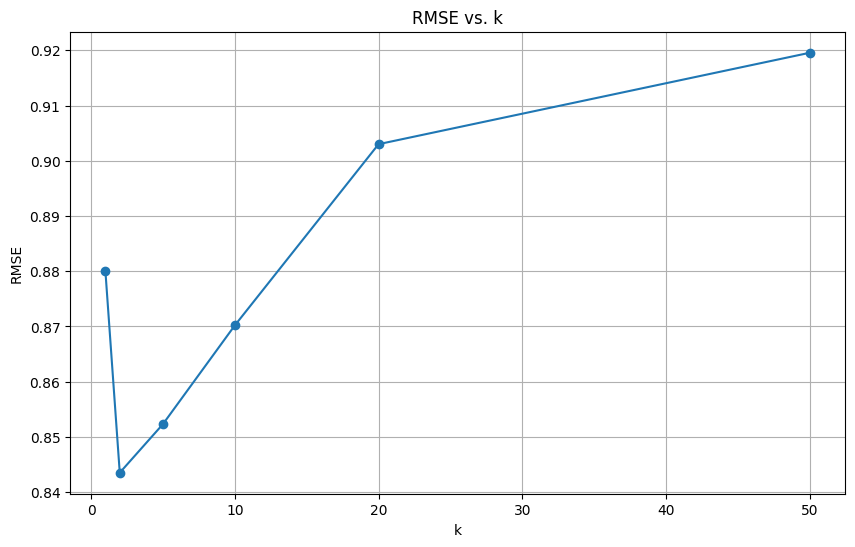

The minimum RMSE is 0.8435096222245063 for k = 2


In [22]:
# Plot the RMSE values
rmse_values_df = pd.DataFrame(list(rmse_values.items()), columns=['k', 'RMSE'])
plt.figure(figsize=(10, 6))
plt.plot(rmse_values_df['k'], rmse_values_df['RMSE'], marker='o')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('RMSE vs. k')
plt.grid()
plt.show()
K_optimal = min(rmse_values, key=rmse_values.get)
print(f"The minimum RMSE is {min(rmse_values.values())} for k = {min(rmse_values, key=rmse_values.get)}")

- KNN - with SVD
The minimum RMSE is 0.896386455881881 for k = 50
- KNN - with WEIGHTED SVD
The minimum RMSE is 0.8435096222245063 for k = 2
- KNN - no SVD
The minimum RMSE is 0.928821659909170

In [23]:
if K_optimal < K_th:
    K_optimal = K_th

# Split the genres into separate rows
train = train.assign(genres=train['genres'].str.split('|')).explode('genres')

# Create an empty dictionary to store subtables
temp = {}
for genre in train_fold['genres'].unique():
    temp[genre] = train.loc[train['genres'] == genre].pivot_table(index='userId', columns='movieId', values='normalized_rating')
# Store the filtered subtable in the dictionary
mat = pd.concat(temp, axis=1, names=['genre', 'movieId'])

# K-NN part
# Compute the global mean of all ratings (ignoring NaNs)
global_mean = np.nanmean(mat.to_numpy())
# Fill missing values with the global mean
mat_filled = mat.fillna(global_mean)

# Compute User-User Cosine Similarity
km = 5  # Number of nearest neighbors

# Compute User-User Cosine Similarity
user_similarity = cosine_similarity(mat_filled)
# Set diagonal to 0 to ignore self-similarity
np.fill_diagonal(user_similarity, 0) 
user_sim_df = pd.DataFrame(user_similarity, index=mat.index, columns=mat.index)

In [24]:
# Perform Weighted SVD on the user_category_df
U, S, Vt = weighted_svd(mat.values, k=K_optimal)
mat = pd.DataFrame(U @ S @ Vt, index=mat.index, columns=mat.columns)

In [25]:
ypred = np.zeros(len(test))

# Apply the function to all rows in test_fold
#test['predicted_rating'] = test.apply(predict_rating, axis=1, mat=mat)
test['predicted_rating'] = test.apply(predict_rating_KM, axis=1, mat=mat, k=km, similarity_matrix=user_sim_df)

# Compute RMSE
rmse = np.sqrt(np.mean((test['normalized_rating'] - test['predicted_rating']) ** 2))
print(f"RMSE for k={K_optimal}: {rmse}")

Predicted rating for user 305 on movie Departed, The (2006) (Crime|Drama|Thriller): 1.0077669778006861 - Actual: 0.9577169923269321
Predicted rating for user 368 on movie Sphere (1998) (Sci-Fi|Thriller): -1.5438139749329955 - Actual: -1.4403091759474476
Predicted rating for user 534 on movie Paul Blart: Mall Cop (2009) (Action|Comedy|Crime): -0.09626804507755372 - Actual: 0.4781117586720562
Predicted rating for user 110 on movie Drop Zone (1994) (Action|Thriller): -0.22647436322233408 - Actual: -2.3995196432571992
Predicted rating for user 210 on movie Rise of the Guardians (2012) (Adventure|Animation|Children|Fantasy|IMAX): 0.584668541351944 - Actual: 0.9577169923269321
Predicted rating for user 171 on movie Harriet the Spy (1996) (Children|Comedy): -0.07477099401117297 - Actual: 1.4373222259818081
Predicted rating for user 52 on movie Illusionist, The (2006) (Drama|Fantasy|Mystery|Romance): 0.8974994556839787 - Actual: 1.4373222259818081
Predicted rating for user 266 on movie Hard Da

- K-NN: So for k=50 we obtain a final RMSE: 0.9557353915235269 on the test dataset
- K-NN with weighted: So for k=10 we obtain a final RMSE: 0.896207569292445 on the test dataset
- Simple K-NN: We obtain a final RMSE: 0.9561701418581131 on the test dataset

## 6 Recommend Movies
Based on the matrix of predictions we just computed we can recommend top-rated movies based on predicted ratings

In [26]:
def plot_genre_wordcloud(user_id, original_data):
    # Filter the data for the given user
    user_data = original_data[original_data['userId'] == user_id]

    # Calculate the average rating for each genre
    genre_ratings = {}
    for genres, rating in zip(user_data['genres'], user_data['rating']):
        for genre in genres.split('|'):
            if genre in genre_ratings:
                genre_ratings[genre].append(rating)
            else:
                genre_ratings[genre] = [rating]

    # Calculate the average rating for each genre
    avg_genre_ratings = {genre: sum(ratings) / len(ratings) for genre, ratings in genre_ratings.items()}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(avg_genre_ratings)

    # Plot the word cloud
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Genre WordCloud for User {user_id}')
    plt.show()

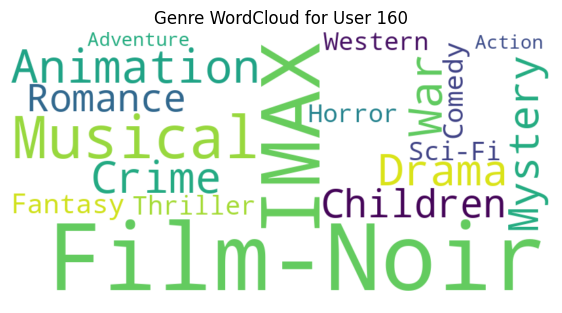

Predicted rating for user 160 on movie Toy Story (1995) (Adventure|Animation|Children|Comedy|Fantasy): 3.1 - Actual: 4.0


/var/folders/qh/3mmvvlx555q853z984k5s_kw0000gp/T/ipykernel_12093/459295274.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_rating = mat.loc[user_id][movie_id]


In [27]:
# Plot the genre word cloud for the user 160
i = 160
user_id = test[test['userId'] == i]['userId'].values[0]
plot_genre_wordcloud(user_id, full_data)

# Predict the rating for the user 1 on the first movie he has not rated
movie_id = full_data[full_data['userId'] == user_id]['movieId'].values[0]
# Denormalize the rating
predicted_rating = mat.loc[user_id][movie_id]
predicted_rating = round(scaler.inverse_transform([[predicted_rating]])[0][0], 1)

print(f"Predicted rating for user {user_id} on movie {movies[movies['movieId'] == movie_id]['title'].values[0]} ({movies[movies['movieId'] == movie_id]['genres'].values[0]}): {predicted_rating} - Actual: {full_data[(full_data['userId'] == user_id) & (full_data['movieId'] == movie_id)]['rating'].values[0]}")

## 7. Hierarchical Clustering
In order to device a more impactful procedure to predict the correct recomendations, we decided to sort the users in the user-item matrix so that the users with higher *cosine similarity* are adjacent:
$$
cos(x,y)=\frac{x\cdot y}{||x||||y||}
$$
To do so, we performed hierarchical clustering on the users and selected the subgroups produced to create such ordering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
# Perform clustering on the train set
# Split the genres into separate rows
train = train.assign(Genres=train['Genres'].str.split('|')).explode('Genres')

# TODO perform CLUSTERING


In [ ]:
# Considering the user_item_matrix, we derive the predicted ratings for each user
# TODO Evaluate clustering

## 8. Evaluation
//TODO: implement some MSE to evaluate our recomendations

In [ ]:
# Evaluate the model using RMSE
from sklearn.metrics import mean_squared_error

# Filter out NaN values
predicted_ratings = predicted_ratings.fillna(0)

# Calculate MSE
rmse = np.sqrt(mean_squared_error(matrix, predicted_matrix))
print("RMSE:", rmse)

## 9. Conclusions
// TODO: write conclusions